# Census income classification with scikit-learn

This example uses the standard <a href="https://archive.ics.uci.edu/ml/datasets/Adult">adult census income dataset</a> from the UCI machine learning data repository. We train a k-nearest neighbors classifier using sci-kit learn and then explain the predictions.

In [1]:
import sklearn
import shap

## Load the census data

In [2]:
X,y = shap.datasets.adult()
X["Occupation"] *= 1000 # to show the impact of feature scale on KNN predictions
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

## Train a k-nearest neighbors classifier

Here we just train directly on the data, without any normalizations.

In [3]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

### Explain predictions

Normally we would use a logit link function to allow the additive feature inputs to better map to the model's probabilistic output space, but knn's can produce infinite log odds ratios so we don't for this example.

It is important to note that Occupation is the dominant feature in the 1000 predictions we explain. This is because it has larger variations in value than the other features and so it impacts the k-nearest neighbors calculations more.

In [8]:
f = lambda x: knn.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_valid.iloc[0:1000, :], error_bounds=True)

Permutation explainer: 1001it [00:47, 16.67it/s]                                                                                                                                                                  


In [7]:
?explainer

In [9]:
shap_values.error_std

array([[0.13446828, 0.        , 0.        , ..., 0.11321908, 0.        ,
        0.        ],
       [0.20563682, 0.13360853, 0.19743535, ..., 0.        , 0.19582417,
        0.        ],
       [0.11268328, 0.        , 0.        , ..., 0.        , 0.15950336,
        0.        ],
       ...,
       [0.40202573, 0.46980952, 0.12041082, ..., 0.        , 0.        ,
        0.        ],
       [0.23650346, 0.        , 0.14569299, ..., 0.        , 0.        ,
        0.        ],
       [0.12601981, 0.        , 0.10155811, ..., 0.        , 0.        ,
        0.        ]])

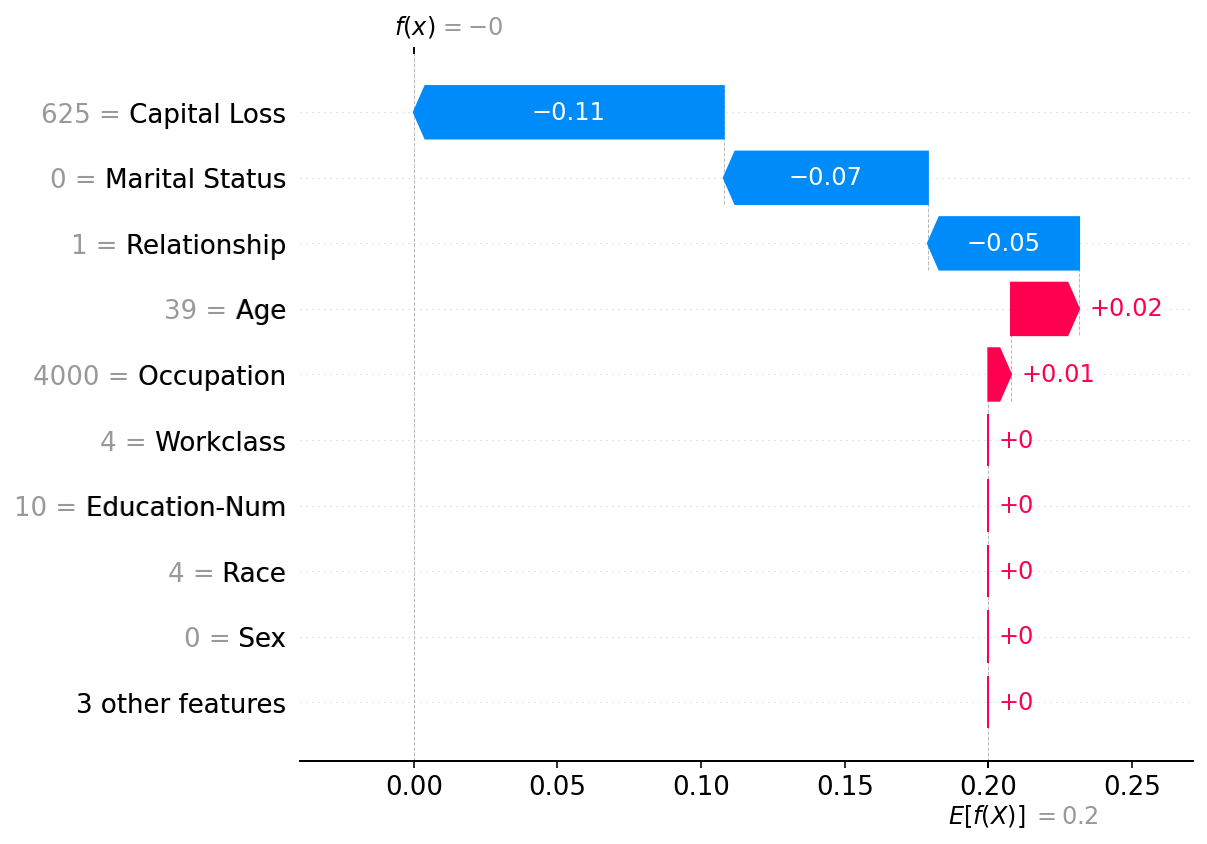

In [5]:
shap.plots.waterfall(shap_values[0])

A summary beeswarm plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

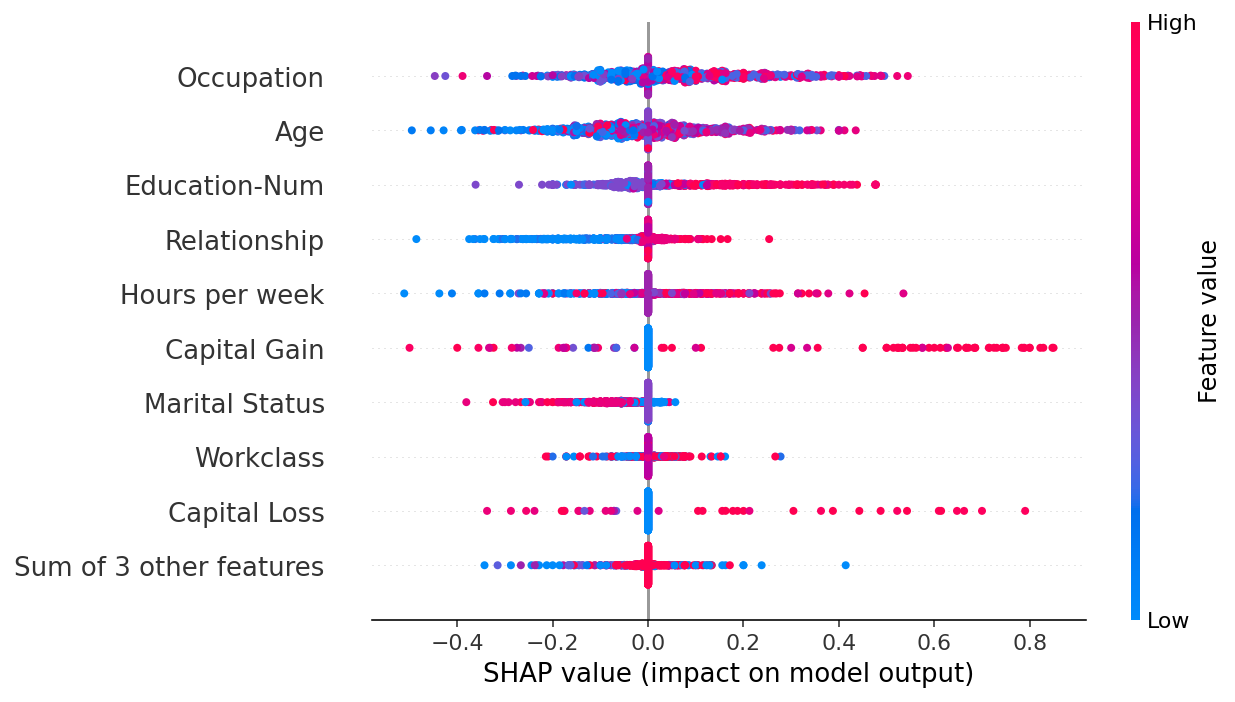

In [7]:
shap.plots.beeswarm(shap_values)

A heatmap plot provides another global view of the model's behavior, this time with a focus on population subgroups.

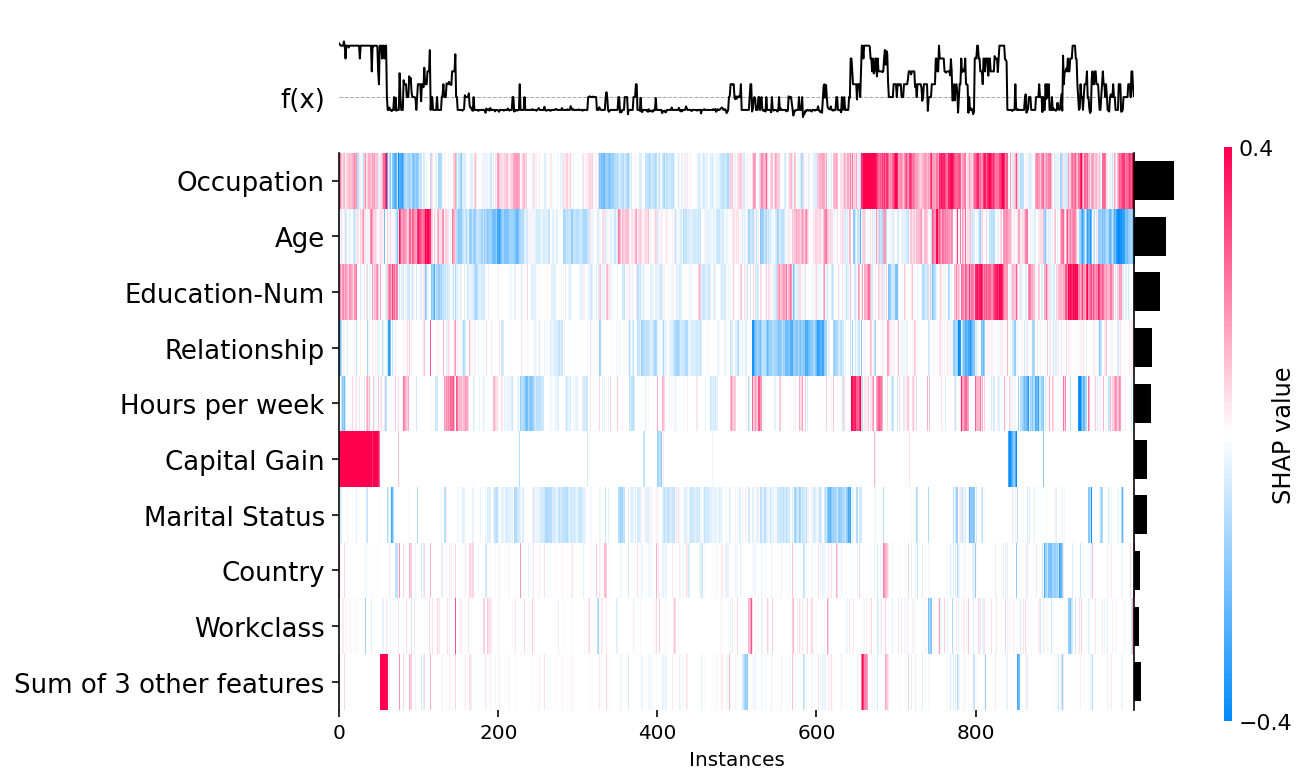

In [8]:
shap.plots.heatmap(shap_values)

## Normalize the data before training the model

Here we retrain a KNN model on standardized data.

In [9]:
# normalize data
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k,dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s
    
    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

In [10]:
knn_norm = sklearn.neighbors.KNeighborsClassifier()
knn_norm.fit(X_train_norm, y_train)

KNeighborsClassifier()

### Explain predictions

When we explain predictions from the new KNN model we find that Occupation is no longer the dominate feature, but instead more predictive features, such as marital status, drive most predictions. This is simple example of how explaining why your model is making it's predicitons can uncover problems in the training process.

In [11]:
f = lambda x: knn_norm.predict_proba(x)[:,1]
med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))

explainer = shap.Explainer(f, med)

shap_values_norm = explainer(X_valid_norm.iloc[0:1000,:])

Permutation explainer: 1001it [01:26, 11.55it/s]                         


With a summary plot with see marital status is the most important on average, but other features (such as captial gain) can have more impact on a particular individual.

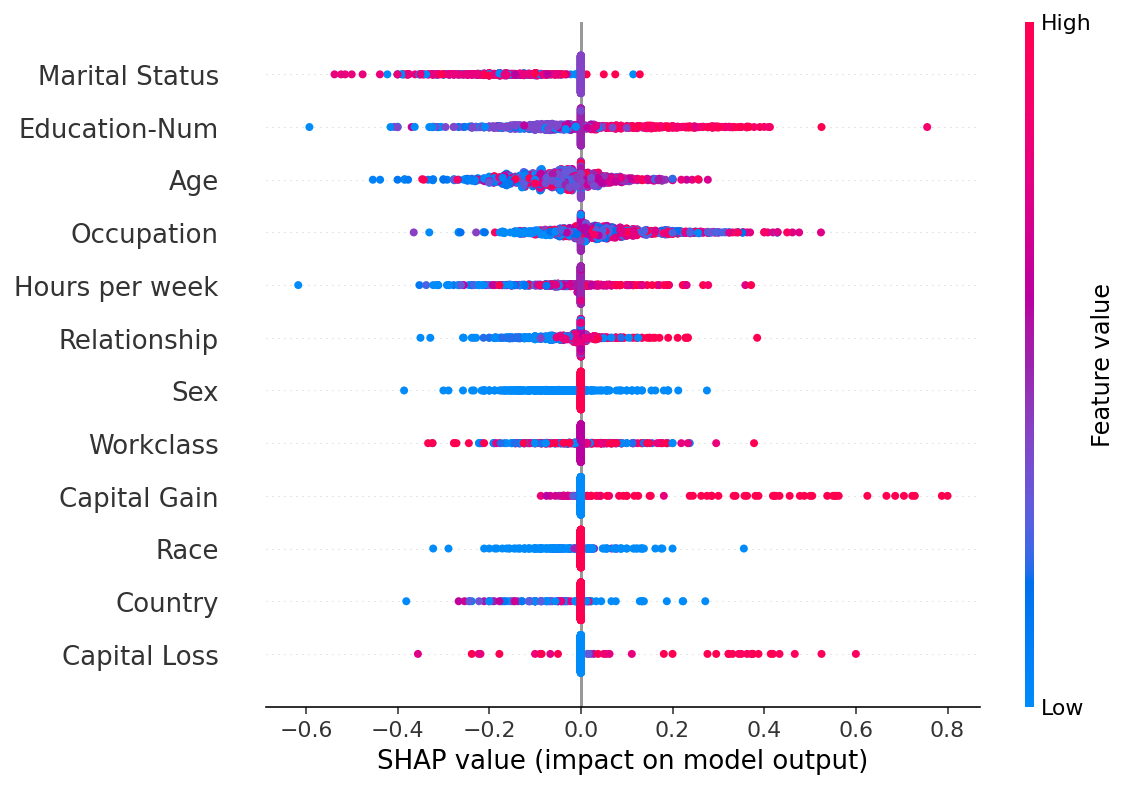

In [12]:
shap.summary_plot(shap_values_norm, X_valid.iloc[0:1000,:])

A dependence scatter plot shows how the number of years of education increases the chance of making over 50K annually.

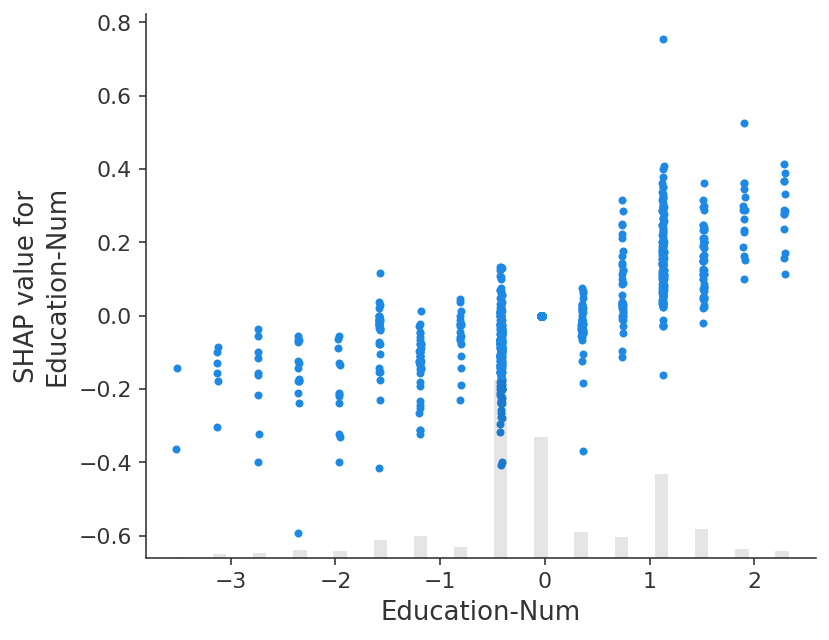

In [14]:
shap.plots.scatter(shap_values_norm[:,"Education-Num"])

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 